In [1]:
#pip install --upgrade pip
## limit the version of JAX for now due to some breaking
## changes introduced in JAX 0.4.16.
#pip install --upgrade "jax[cuda11_pip]<0.4.16" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#pip install hssm

In [2]:
#!pip install numpy==1.23.4
#!pip install git+https://github.com/lnccbrown/hssm@main
#!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
#!pip install numpyro

In [3]:
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

from jax.config import config
config.update("jax_enable_x64", False)

/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
data_path = 'data_ddm.csv'
df = pd.read_csv(data_path)
df

,id,cond,choice,rt
0,1,pro,correct,268
1,1,pro,correct,286
2,1,pro,correct,390
3,1,pro,correct,234
4,1,pro,correct,186
...,...,...,...,...
35611,o89,pro,correct,280
35612,o89,pro,correct,418
35613,o89,pro,correct,276
35614,o89,pro,correct,198


My dataset:

In [12]:
# Load the dataset
data_path = 'data_ddm.csv'
df = pd.read_csv(data_path)

# Drop all columns except 'rt' and 'choice'
df_modified = df[['rt', 'choice']].copy()

# Rename 'choice' column to 'response'
df_modified.rename(columns={'choice': 'response'}, inplace=True)

# Replace 'correct' with 1.0 and any other value with -1.0 in 'response' column
df_modified['response'] = df_modified['response'].apply(lambda x: 1.0 if x == 'correct' else -1.0)

df_modified['rt'] = df_modified['rt'] / 1000.0
dataset = df_modified 
dataset

,rt,response
0,0.268,1.0
1,0.286,1.0
2,0.390,1.0
3,0.234,1.0
4,0.186,1.0
...,...,...
35611,0.280,1.0
35612,0.418,1.0
35613,0.276,1.0
35614,0.198,1.0


as discussed, instead of fitting all parameters of the DDM, qe want to fit only the `v` (drift) parameter, setting all other parameters to fixed scalar values.


In [5]:
ddm_model_only_v = hssm.HSSM(data=dataset, model="ddm", a=1.5, t=0.2, z=0.5)

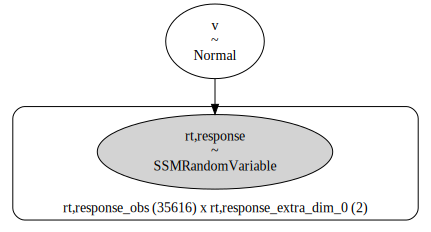

In [6]:
ddm_model_only_v.graph()

In [7]:
ddm_model_only_v.sample(
    sampler="nuts_numpyro",
    chains=4,
    cores=12,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=False),  
)

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Compilation time = 0:00:03.805524
Sampling...
/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]


Running chain 0:   5%|▌         | 100/2000 [00:02<00:02, 671.68it/s]


Running chain 0:  10%|█         | 200/2000 [00:02<00:03, 585.17it/s]

Running chain 0:  15%|█▌        | 300/2000 [00:02<00:02, 706.01it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:02<00:01, 87

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

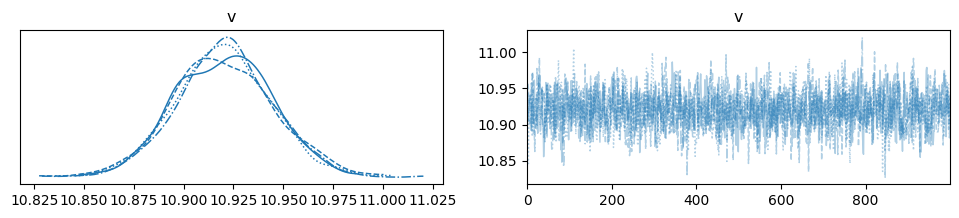

In [8]:
az.plot_trace(ddm_model_only_v.traces)


/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

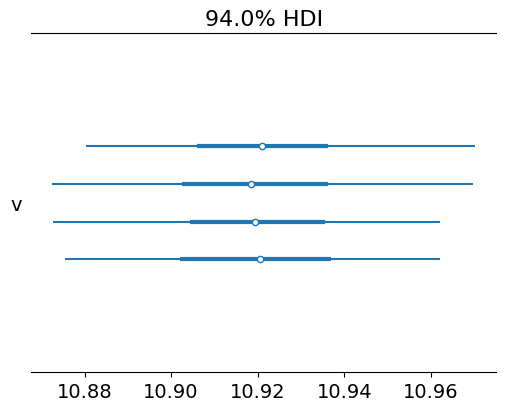

In [9]:
az.plot_forest(ddm_model_only_v.traces)

In [11]:
# Question 1 - should i play with the prior specification? looks solid already

----

---

---

In [ ]:
#another version, not sure about that


with the assumption only v is actually driven by a trial-by-trial regression, I tryto fit a hierarchical model now. 

We define a group mean mean_v and a group standard deviation sd_v for the intercept parameter of the regression on v, which we sample from a corresponding normal distribution for each subject.

loading the data again:

In [51]:

data_path = 'data_ddm.csv'
data_ddm = pd.read_csv(data_path)

data_ddm['response'] = data_ddm['choice'].map({'correct': 1, 'error': -1})

assert data_ddm['response'].isin([-1, 1]).all(), "Response column contains values other than -1 and 1."

def convert_id(id_str):
    try:
        return int(id_str)
    except ValueError:
        return id_str

data_ddm['id'] = data_ddm['id'].apply(convert_id)
max_young_id = max(i for i in data_ddm['id'] if isinstance(i, int))

def finalize_id(id_val):
    return int(id_val.replace('o', '')) + max_young_id if isinstance(id_val, str) else id_val

data_ddm['id'] = data_ddm['id'].apply(finalize_id)

data_list = []
unique_subjects = data_ddm['id'].unique()
for subject in unique_subjects:
    subject_data = data_ddm[data_ddm['id'] == subject]
    
    data_list.append(
        pd.DataFrame(
            {
                "rt": subject_data['rt'],
                "response": subject_data['response'],
                "cond": subject_data['cond'],
                "subject": subject,
            }
        )
    )

dataset_reg_v_hier = pd.concat(data_list, ignore_index=True)
dataset_reg_v_hier

,rt,response,cond,subject
0,268,1,pro,1
1,286,1,pro,1
2,390,1,pro,1
3,234,1,pro,1
4,186,1,pro,1
...,...,...,...,...
35611,280,1,pro,174
35612,418,1,pro,174
35613,276,1,pro,174
35614,198,1,pro,174


In [44]:
print('Shape of rt:', dataset_reg_v_hier['rt'].shape)
print('Shape of response:', dataset_reg_v_hier['response'].shape)
print('Shape of cond:', dataset_reg_v_hier['cond'].shape)
print('Shape of subject:', dataset_reg_v_hier['subject'].shape)

if not all(isinstance(dataset_reg_v_hier[col], pd.Series) for col in ['rt', 'response', 'cond', 'subject']):
    raise ValueError("One or more columns in the dataset are not Pandas Series.")

Shape of rt: (35616,)
Shape of response: (35616,)
Shape of cond: (35616,)
Shape of subject: (35616,)


In [55]:
mean_rt = dataset_reg_v_hier['rt'].mean()
std_rt = dataset_reg_v_hier['rt'].std()



In [ ]:
model_reg_v_angle_hier.graph()

In [57]:
model_reg_v_angle_hier = hssm.HSSM(
    data=dataset_reg_v_hier,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": mean_rt,  # Centered around the mean RT
                    "sigma": std_rt,  # standard deviation
                },
                "cond": {
                    "name": "Normal",
                    "mu": 0,  # Centered around 0, indicating no effect as a starting assumption
                    "sigma": std_rt / 2,  # A smaller standard deviation than for the intercept
                },
            },
            "formula": "v ~ 1 + (1|subject) + cond",
            "link": "identity",
        }
    ],
)


In [58]:
config.update("jax_enable_x64", False)
model_reg_v_angle_hier.sample(
    sampler="nuts_numpyro", chains=2, cores=12, draws=1000, tune=1000
)

Compiling...
Compilation time = 0:00:04.145627
Sampling...
/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
Running chain 1: 100%|██████████| 2000/2000 [10:14<00:00,  3.26it/s]
Sampling time = 0:10:14.811404
Transforming variables...
Transformation time = 0:00:00.238512


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

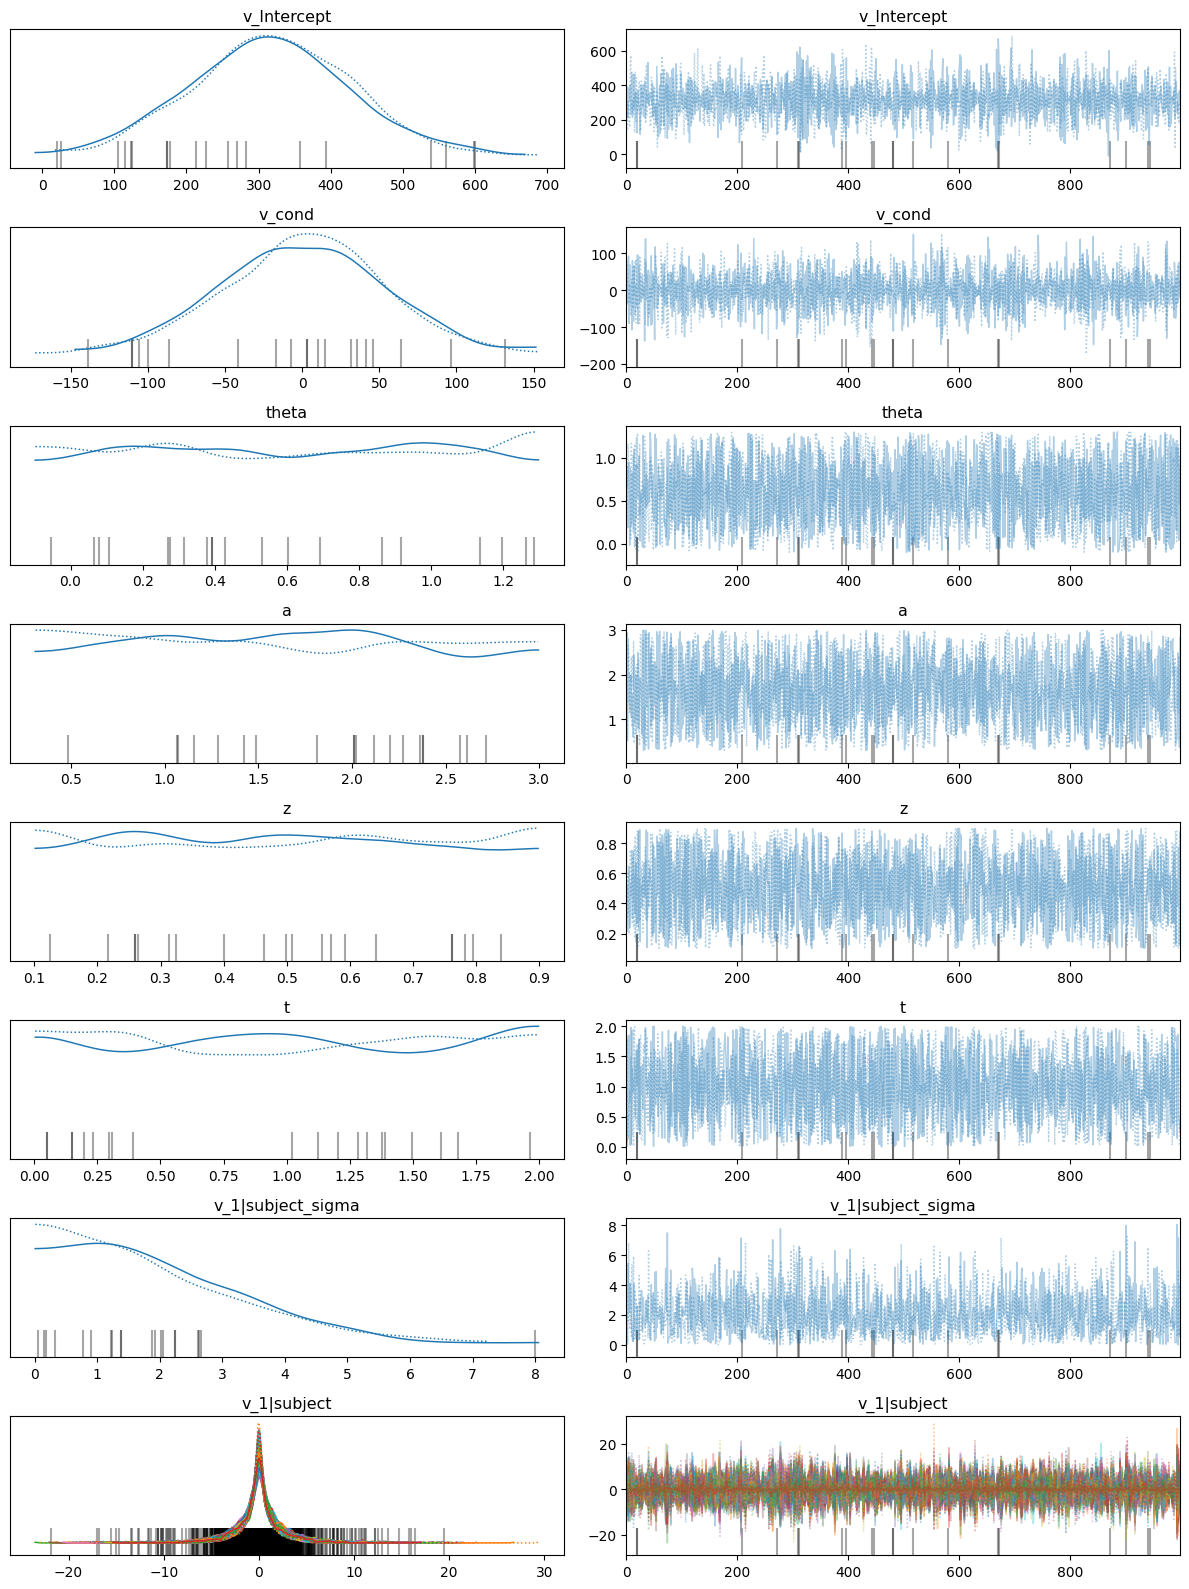

In [59]:
az.plot_trace(model_reg_v_angle_hier.traces)
plt.tight_layout()

/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/ubuntu/hddm/.denv/lib/python3.11/site-packages/arviz/plots

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

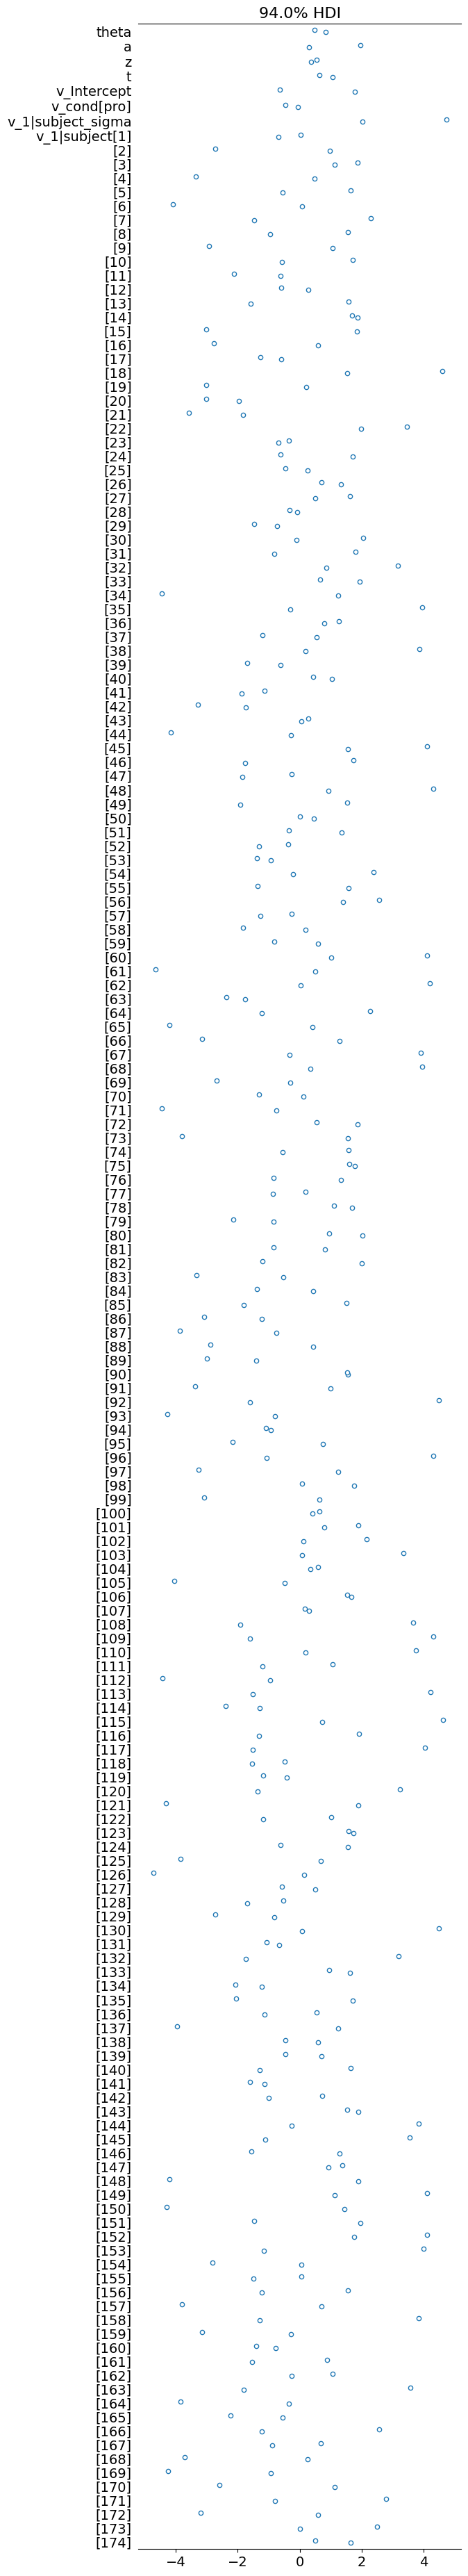

In [48]:
az.plot_forest(model_reg_v_angle_hier.traces)
